In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision
from tqdm.auto import tqdm

from read_all_as_df import read_all_as_df

In [2]:
pd.options.mode.chained_assignment = None
sns.set_style("darkgrid")

In [3]:
PATH = os.path.join("runs", "keep", "paper_runs")

df_runs = read_all_as_df(PATH)
df_runs

,agent,metric,run_name,step,value
0,pursuer_0,total_reward,a2c_distance_256its,0,30.848604
1,pursuer_0,total_reward,a2c_distance_256its,1,53.971176
2,pursuer_0,total_reward,a2c_distance_256its,2,54.810173
3,pursuer_0,total_reward,a2c_distance_256its,3,53.892242
4,pursuer_0,total_reward,a2c_distance_256its,4,174.038101
...,...,...,...,...,...
30331,pursuer_1,test_total_reward,random_256its,246,58.264996
30332,pursuer_1,test_total_reward,random_256its,248,140.708649
30333,pursuer_1,test_total_reward,random_256its,250,21.971367
30334,pursuer_1,test_total_reward,random_256its,252,108.199760


In [4]:
print(*df_runs["run_name"].unique(), sep=", ")
print(*df_runs["metric"].unique(), sep=", ")

a2c_distance_256its, a2c_distance_lstm_256its, a2c_simple_256its, a2c_simple_lstm_256its, controls_256its, cpt_distance_768its, ddpg_distance_256its, ddpg_distance_cpt_768its, ddpg_distance_lstm_256its, ddpg_simple_256its, ddpg_simple_lstm_256its, qnn_distance_256its, qnn_distance_lstm_256its, qnn_simple_256its, qnn_simple_lstm_256its, random_256its
total_reward, loss, critic_loss, actor_loss, test_total_reward


In [5]:
df_runs["original_run_name"] = df_runs["run_name"]

In [6]:
def parse_run_name(name: str):
    parts = name.split("_")[:-1]
    if len(parts) > 1:
        parts[0] = parts[0].upper()
        parts[1] = parts[1][0].upper() + parts[1][1:]
    else:
        parts[0] = parts[0][0].upper() + parts[0][1:]
    if len(parts) > 2:
        parts[2] = parts[2].upper()
    return " ".join(parts)

In [7]:
df_runs["run_name"] = (
    df_runs["original_run_name"].map(parse_run_name)
)
df_runs["agent_type"] = df_runs["run_name"].str.split(" ").apply(lambda l: l[0]).astype("category")
df_runs["network_type"] = df_runs["run_name"].str.split(" ").apply(lambda l: l[min(len(l) - 1, 1)]).astype("category")
df_runs["has_lstm"] = df_runs["run_name"].str.contains("LSTM")
df_runs["memory"] = df_runs["agent"].map(lambda a: "Reward Prioritized Memory" if a == "pursuer_1" else "Normal Memory")

df_runs

,agent,metric,run_name,step,value,original_run_name,agent_type,network_type,has_lstm,memory
0,pursuer_0,total_reward,A2C Distance,0,30.848604,a2c_distance_256its,A2C,Distance,False,Normal Memory
1,pursuer_0,total_reward,A2C Distance,1,53.971176,a2c_distance_256its,A2C,Distance,False,Normal Memory
2,pursuer_0,total_reward,A2C Distance,2,54.810173,a2c_distance_256its,A2C,Distance,False,Normal Memory
3,pursuer_0,total_reward,A2C Distance,3,53.892242,a2c_distance_256its,A2C,Distance,False,Normal Memory
4,pursuer_0,total_reward,A2C Distance,4,174.038101,a2c_distance_256its,A2C,Distance,False,Normal Memory
...,...,...,...,...,...,...,...,...,...,...
30331,pursuer_1,test_total_reward,Random,246,58.264996,random_256its,Random,Random,False,Reward Prioritized Memory
30332,pursuer_1,test_total_reward,Random,248,140.708649,random_256its,Random,Random,False,Reward Prioritized Memory
30333,pursuer_1,test_total_reward,Random,250,21.971367,random_256its,Random,Random,False,Reward Prioritized Memory
30334,pursuer_1,test_total_reward,Random,252,108.199760,random_256its,Random,Random,False,Reward Prioritized Memory


In [8]:
# Truncate steps
min_max_steps = min(df_runs["original_run_name"].str.split("_").map(lambda l: int(l[-1][:-3])))
df_runs.query("step <= @min_max_steps", inplace=True)

In [9]:
print(*df_runs["run_name"].unique(), sep=", ")

A2C Distance, A2C Distance LSTM, A2C Simple, A2C Simple LSTM, Controls, CPT Distance, DDPG Distance, DDPG Distance CPT, DDPG Distance LSTM, DDPG Simple, DDPG Simple LSTM, QNN Distance, QNN Distance LSTM, QNN Simple, QNN Simple LSTM, Random


# QNN vs A2C vs DDPG vs Controls vs Random

agent_type
A2C          84.767738
Controls    216.745977
DDPG         25.048716
QNN          13.036532
Random       87.680823
Name: value, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


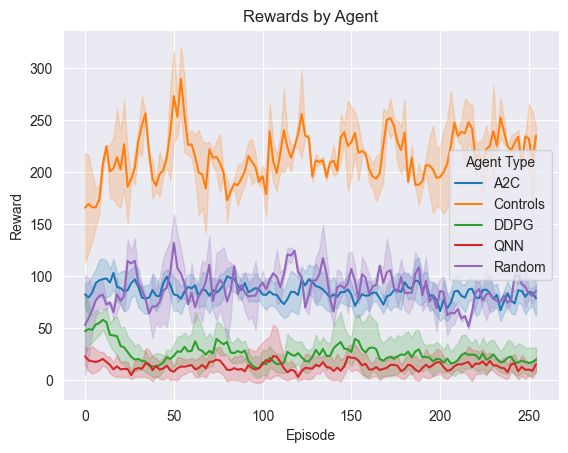

In [10]:
to_plot = (
    df_runs.query("metric == 'test_total_reward'")
    .query("agent_type != 'CPT'")
    .query("run_name != 'DDPG Distance CPT'")
)
to_plot["agent_type"] = to_plot["agent_type"].cat.remove_unused_categories()

means = to_plot.groupby(by="agent_type")["value"].mean()
print(means)

to_plot["smoothed_value"] = to_plot["value"].ewm(alpha=1 - 0.65).mean()
plot = sns.lineplot(data=to_plot, x="step", y="smoothed_value", hue="agent_type")
plot.set_xlabel("Episode")
plot.set_ylabel("Reward")
plot.set_title("Rewards by Agent")
plot.legend(title="Agent Type")
plot.figure.savefig("rewards-by-agent.eps", format="eps")

# RPM vs Normal Memory

In [11]:
to_plot = (
    df_runs.query("metric == 'loss' or metric == 'actor_loss'")
    .query("agent_type != 'CPT'")
    .query("run_name != 'DDPG Distance CPT'")
)
to_plot["agent_type"] = to_plot["agent_type"].cat.remove_unused_categories()

to_plot["Smoothed Loss"] = (
    to_plot.groupby(by=["agent_type", "memory"])["value"]
    .ewm(alpha=1 - 0.999)
    .mean()
    .reset_index()
    .set_index("level_2")
    .drop(columns=["agent_type", "memory"])
)

for type_ in to_plot["agent_type"].unique():
    plot = sns.lineplot(
        data=to_plot.query("agent_type == @type_"),
        x="step",
        y="Smoothed Loss",
        hue="memory",
    )
    plot.set_xlabel("Episode")
    plot.set_ylabel("(Actor) Loss")
    plot.set_title("Loss by Memory Type")
    plot.legend(title="Memory Type")
    plot.figure.savefig(f"loss-by-memory-{type_}.eps", format="eps")
    plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# Simple vs Distance vs Simple LSTM vs Distance LSTM

In [12]:
to_plot = (
    df_runs.query("metric == 'test_total_reward'")
    .query("agent_type != 'CPT'")
    .query("run_name != 'DDPG Distance CPT'")
    .query("agent_type != 'Controls'")
    .query("agent_type != 'Random'")
)
to_plot["agent_type"] = to_plot["agent_type"].cat.remove_unused_categories()
to_plot["network_type"] = to_plot["network_type"].cat.remove_unused_categories()

to_plot["type"] = to_plot["agent_type"].astype(str) + " " + to_plot["network_type"].astype(str) + to_plot["has_lstm"].map(
    lambda lstm: " LSTM" if lstm else ""
)

means = to_plot.groupby(by=["type"])["value"].mean()
print(means)
to_plot["smoothed_value"] = to_plot["value"].ewm(alpha=1 - 0.999).mean()

for type_ in to_plot["agent_type"].unique():
    plot = sns.lineplot(
        data=to_plot.query("agent_type == @type_"),
        x="step",
        y="smoothed_value",
        hue="type",
    )
    plot.set_xlabel("Episode")
    plot.set_ylabel("Reward")
    plot.set_title("Rewards by Agent and Network Type")
    plot.legend(title="Architecture")
    plot.figure.savefig(f"rewards-by-architecture-{type_}.eps", format="eps")
    plt.close()

type
A2C Distance          86.605331
A2C Distance LSTM     82.846228
A2C Simple            87.257515
A2C Simple LSTM       82.361878
DDPG Distance         14.533167
DDPG Distance LSTM    35.855946
DDPG Simple           14.298372
DDPG Simple LSTM      35.507380
QNN Distance           7.189058
QNN Distance LSTM     23.794982
QNN Simple            10.981836
QNN Simple LSTM       10.180254
Name: value, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# DDPG vs CPT DDPG

run_name
DDPG Distance        14.533167
DDPG Distance CPT    19.649900
Name: value, dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


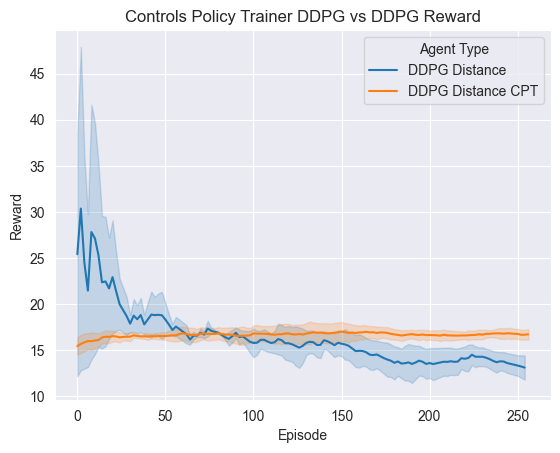

In [13]:
to_plot = (
    df_runs.query("metric == 'test_total_reward'")
    .query("run_name == 'DDPG Distance CPT' or run_name == 'DDPG Distance'")
)
to_plot["run_name"] = to_plot["run_name"].cat.remove_unused_categories()

means = to_plot.groupby(by="run_name")["value"].mean()
print(means)

to_plot["smoothed_value"] = to_plot["value"].ewm(alpha=1 - 0.999).mean()
plot = sns.lineplot(data=to_plot, x="step", y="smoothed_value", hue="run_name")
plot.set_xlabel("Episode")
plot.set_ylabel("Reward")
plot.set_title("Controls Policy Trainer DDPG vs DDPG Reward")
plot.legend(title="Agent Type")
plot.figure.savefig("rewards-by-agent-cpt.eps", format="eps");

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


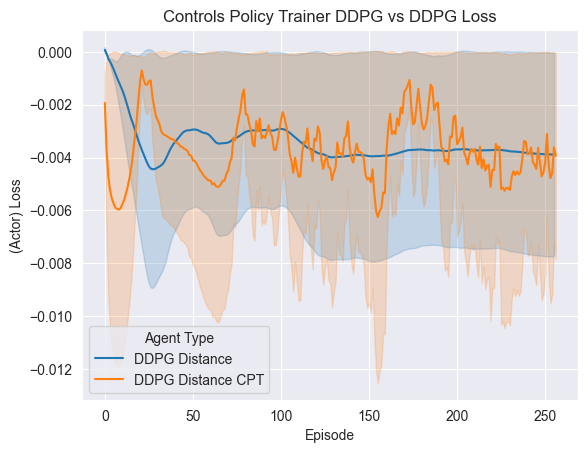

In [14]:
to_plot = (
    df_runs.query("metric == 'actor_loss'")
    .query("run_name == 'DDPG Distance CPT' or run_name == 'DDPG Distance'")
)
to_plot["run_name"] = to_plot["run_name"].cat.remove_unused_categories()

to_plot["smoothed_value"] = to_plot["value"]
plot = sns.lineplot(data=to_plot, x="step", y="smoothed_value", hue="run_name")
plot.set_xlabel("Episode")
plot.set_ylabel("(Actor) Loss")
plot.set_title("Controls Policy Trainer DDPG vs DDPG Loss")
plot.legend(title="Agent Type")
plot.figure.savefig("loss-by-agent-cpt.eps", format="eps");